In [22]:
import os
from dotenv import load_dotenv
# import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
load_dotenv()

True

In [23]:
# Fetch credentials
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

db_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

In [28]:
query = """
    SELECT *
    FROM observations
    """
df = pd.read_sql_query(query, engine)
df.tail(15)

,obs_id,sensor_id,obs_time,temp1,hum1,temp2,hum2
957864,681586,PICO_W_04,2025-07-08 07:16:43,36.22,46.52,36.74,45.21
957865,681587,PICO_W_01,2025-07-08 07:16:44,32.38,58.12,32.25,54.60
957866,681588,PICO_W_03,2025-07-08 07:16:45,35.06,47.39,36.12,45.63
957867,681589,PICO_W_02,2025-07-08 07:16:45,33.28,56.26,33.02,53.53
957868,681590,PICO_W_04,2025-07-08 07:16:44,36.24,46.51,36.73,45.14
957869,681591,PICO_W_01,2025-07-08 07:16:45,32.38,58.10,32.26,54.57
957870,681592,PICO_W_03,2025-07-08 07:16:46,35.06,47.43,36.12,45.72
957871,681593,PICO_W_02,2025-07-08 07:16:46,33.32,56.23,33.00,53.43
957872,681594,PICO_W_04,2025-07-08 07:16:46,36.22,46.59,36.75,45.22
957873,681595,PICO_W_01,2025-07-08 07:16:46,32.37,58.10,32.25,54.60


In [29]:
df['temp'] = (df['temp1'] + df['temp2']) / 2
df['hum'] = (df['hum1'] + df['hum2']) / 2
df['temp_diff'] = df['temp1'] - df['temp2']
df['hum_diff'] = df['hum1'] - df['hum2']

df['temp_f'] = df['temp'] * 9 / 5 + 32

In [39]:
df['interval_start'] = pd.to_datetime(df['obs_time']).dt.floor('10min')
agg = (
    df.groupby(['interval_start', 'sensor_id'],)
        .agg(temp=('temp', 'mean'), hum=('hum', 'mean'))
        .reset_index()
        .rename(columns={'interval_start': 'obs_time'})
)
hist_10m = agg[agg['obs_time'] < agg['obs_time'].max()]

In [40]:
hist_10m

,obs_time,sensor_id,temp,hum
0,2025-07-06 00:00:00,PICO_W_01,28.036165,49.792012
1,2025-07-06 00:00:00,PICO_W_02,29.811470,46.039870
2,2025-07-06 00:00:00,PICO_W_03,30.726545,41.178040
3,2025-07-06 00:00:00,PICO_W_04,31.274562,42.652112
4,2025-07-06 00:10:00,PICO_W_01,27.785606,48.115099
...,...,...,...,...
1902,2025-07-09 07:10:00,PICO_W_04,35.941720,44.513767
1903,2025-07-09 07:20:00,PICO_W_01,32.223300,53.649523
1904,2025-07-09 07:20:00,PICO_W_02,33.418830,50.920230
1905,2025-07-09 07:20:00,PICO_W_03,35.718307,43.841238


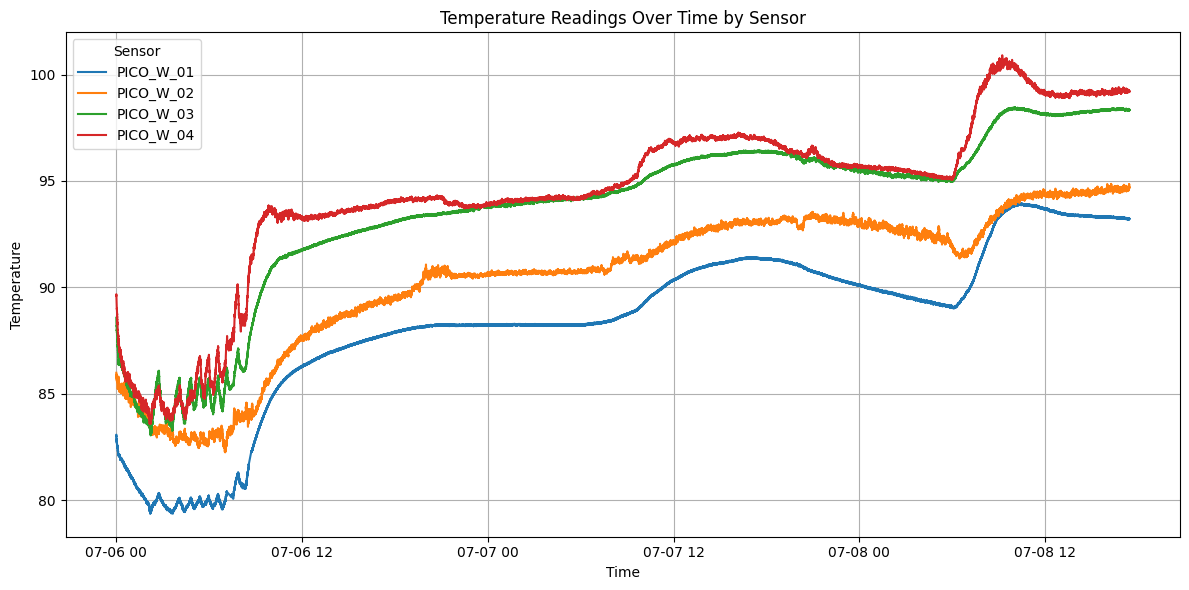

In [5]:
plt.figure(figsize=(12, 6))
legend_order = [
    'PICO_W_01',
    'PICO_W_02',
    'PICO_W_03',
    'PICO_W_04'
]
sns.lineplot(
    data=df,
    x='obs_time',
    y='temp_f',
    hue='sensor_id',
    palette='tab10',
    hue_order=legend_order
)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Readings Over Time by Sensor')
plt.legend(title='Sensor')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df_samp = df[df['sensor_id']=='PICO_W_03']
t = df_samp['obs_time']
x = df_samp['temp']

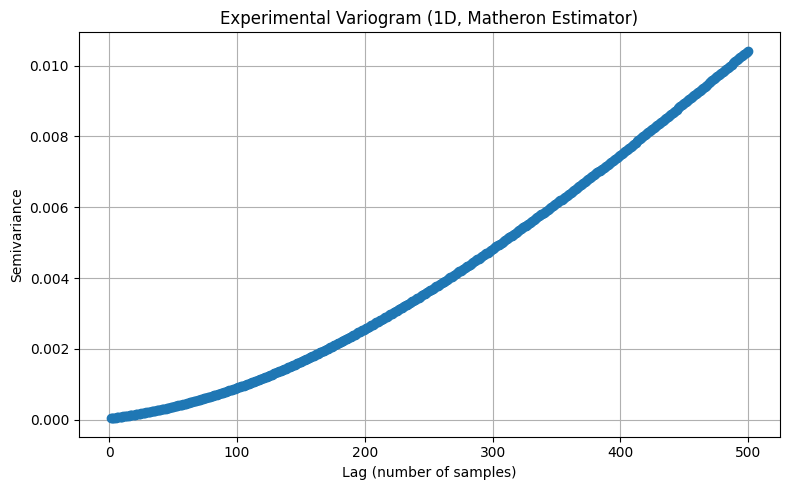

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# x = your 1D numpy array of data (e.g., temperature)
x = df_samp['temp'].to_numpy()
max_lag = 500  # Adjust as needed (in number of samples)

lags = np.arange(1, max_lag + 1)
variogram = np.zeros_like(lags, dtype=float)

for idx, h in enumerate(lags):
    diffs = x[h:] - x[:-h]
    variogram[idx] = 0.5 * np.mean(diffs**2)

plt.figure(figsize=(8, 5))
plt.plot(lags, variogram, marker='o')
plt.xlabel('Lag (number of samples)')
plt.ylabel('Semivariance')
plt.title('Experimental Variogram (1D, Matheron Estimator)')
plt.grid(True)
plt.tight_layout()
plt.show()


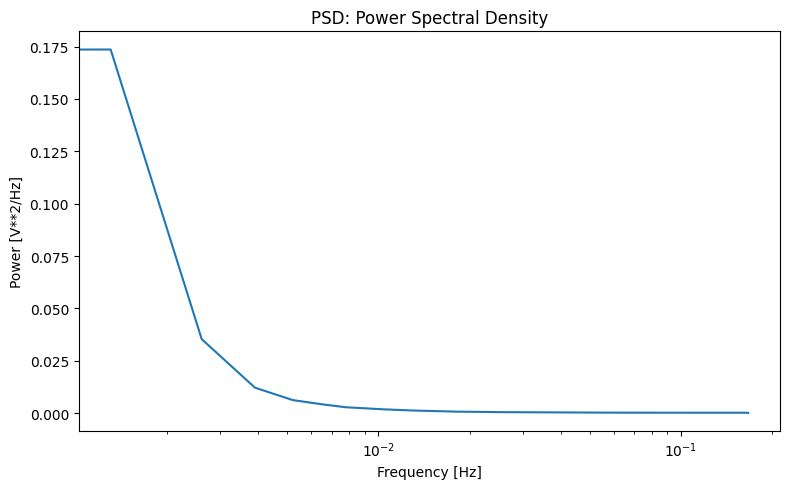

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

t = df_samp['obs_time']
x = df_samp['temp'].to_numpy()

fs = 1/3  # Sampling frequency: one sample every 3 seconds

# Compute PSD using Welch's method
f, psd = signal.welch(x, fs=fs, nperseg=256)  # Adjust nperseg as needed

# Plot the PSD
plt.figure(figsize=(8, 5))
plt.semilogx(f, psd)
plt.title('PSD: Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [V**2/Hz]')
plt.tight_layout()
plt.show()

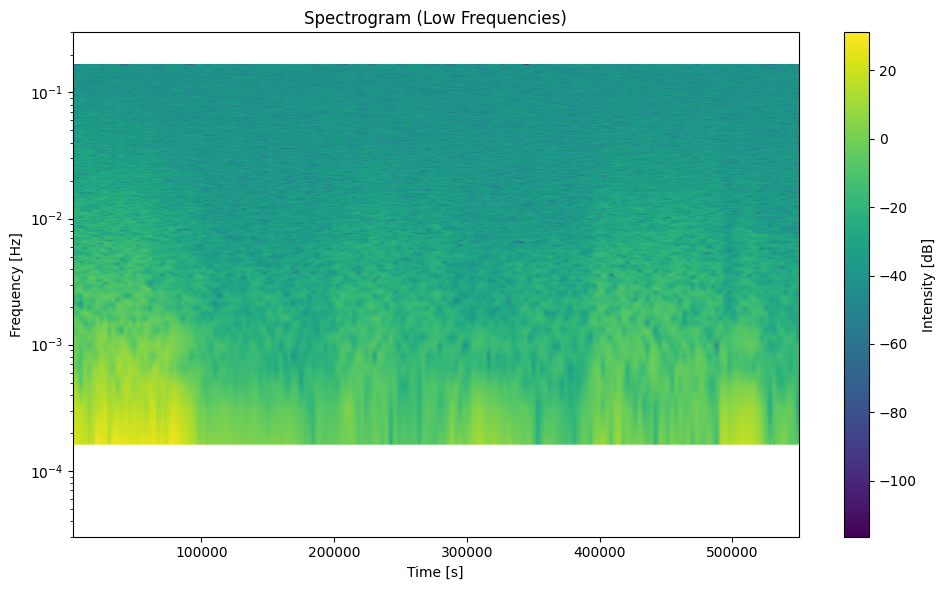

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 1/3  # One sample every 3 seconds

# Choose a large window for low frequency resolution
nperseg = 2048  # Try increasing if your data is long enough - 4096
noverlap = nperseg // 2

# Compute the spectrogram
f, t_spec, Sxx = signal.spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Limit to your frequency range of interest
fmin, fmax = 0.00003, 0.3
freq_mask = (f >= fmin) & (f <= fmax)
f_plot = f[freq_mask]
Sxx_plot = Sxx[freq_mask, :]

plt.figure(figsize=(10, 6))
plt.pcolormesh(t_spec, f_plot, 10 * np.log10(Sxx_plot), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (Low Frequencies)')
plt.colorbar(label='Intensity [dB]')
plt.yscale('log')  # Optional: log scale for frequency axis
plt.ylim(fmin, fmax)
plt.tight_layout()
plt.show()

In [ ]:
# df_long = df.melt(
#     id_vars=['obs_time', 'sensor_id'],
#     value_vars=['temp1', 'temp2'],
#     var_name='temp_type',
#     value_name='temperature'
# )

# # Combine sensor_id and temp_type for unique line labels
# df_long['label'] = df_long['sensor_id'] + ' ' + df_long['temp_type']

# # Convert temperature from Celsius to Fahrenheit
# df_long['temperature'] = df_long['temperature'] * 9 / 5 + 32

# # df_long

In [ ]:
# plt.figure(figsize=(12, 6))
# legend_order = [
#     'PICO_W_01 temp1', 'PICO_W_01 temp2',
#     'PICO_W_02 temp1', 'PICO_W_02 temp2',
#     'PICO_W_03 temp1', 'PICO_W_03 temp2',
#     'PICO_W_04 temp1', 'PICO_W_04 temp2'
# ]
# sns.lineplot(
#     data=df_long,
#     x='obs_time',
#     y='temperature',
#     hue='label',
#     palette='tab10',
#     hue_order=legend_order
# )

# plt.xlabel('Time')
# plt.ylabel('Temperature')
# plt.title('Temperature Readings Over Time by Sensor and Type')
# plt.legend(title='Sensor & Temp Type')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

NameError: name 'df_long' is not defined

<Figure size 1200x600 with 0 Axes>

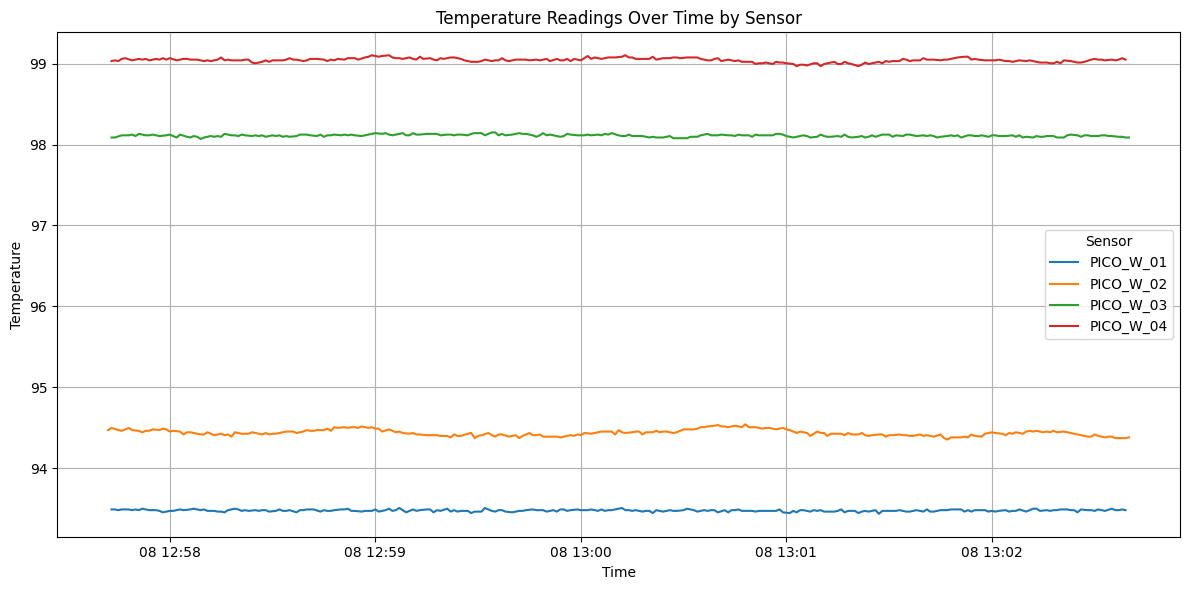

In [8]:
plt.figure(figsize=(12, 6))
legend_order = [
    'PICO_W_01',
    'PICO_W_02',
    'PICO_W_03',
    'PICO_W_04'
]
sns.lineplot(
    data=df.tail(1000),
    x='obs_time',
    y='temp_f',
    hue='sensor_id',
    palette='tab10',
    hue_order=legend_order
)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Readings Over Time by Sensor')
plt.legend(title='Sensor')
plt.grid(True)
plt.tight_layout()
plt.show()

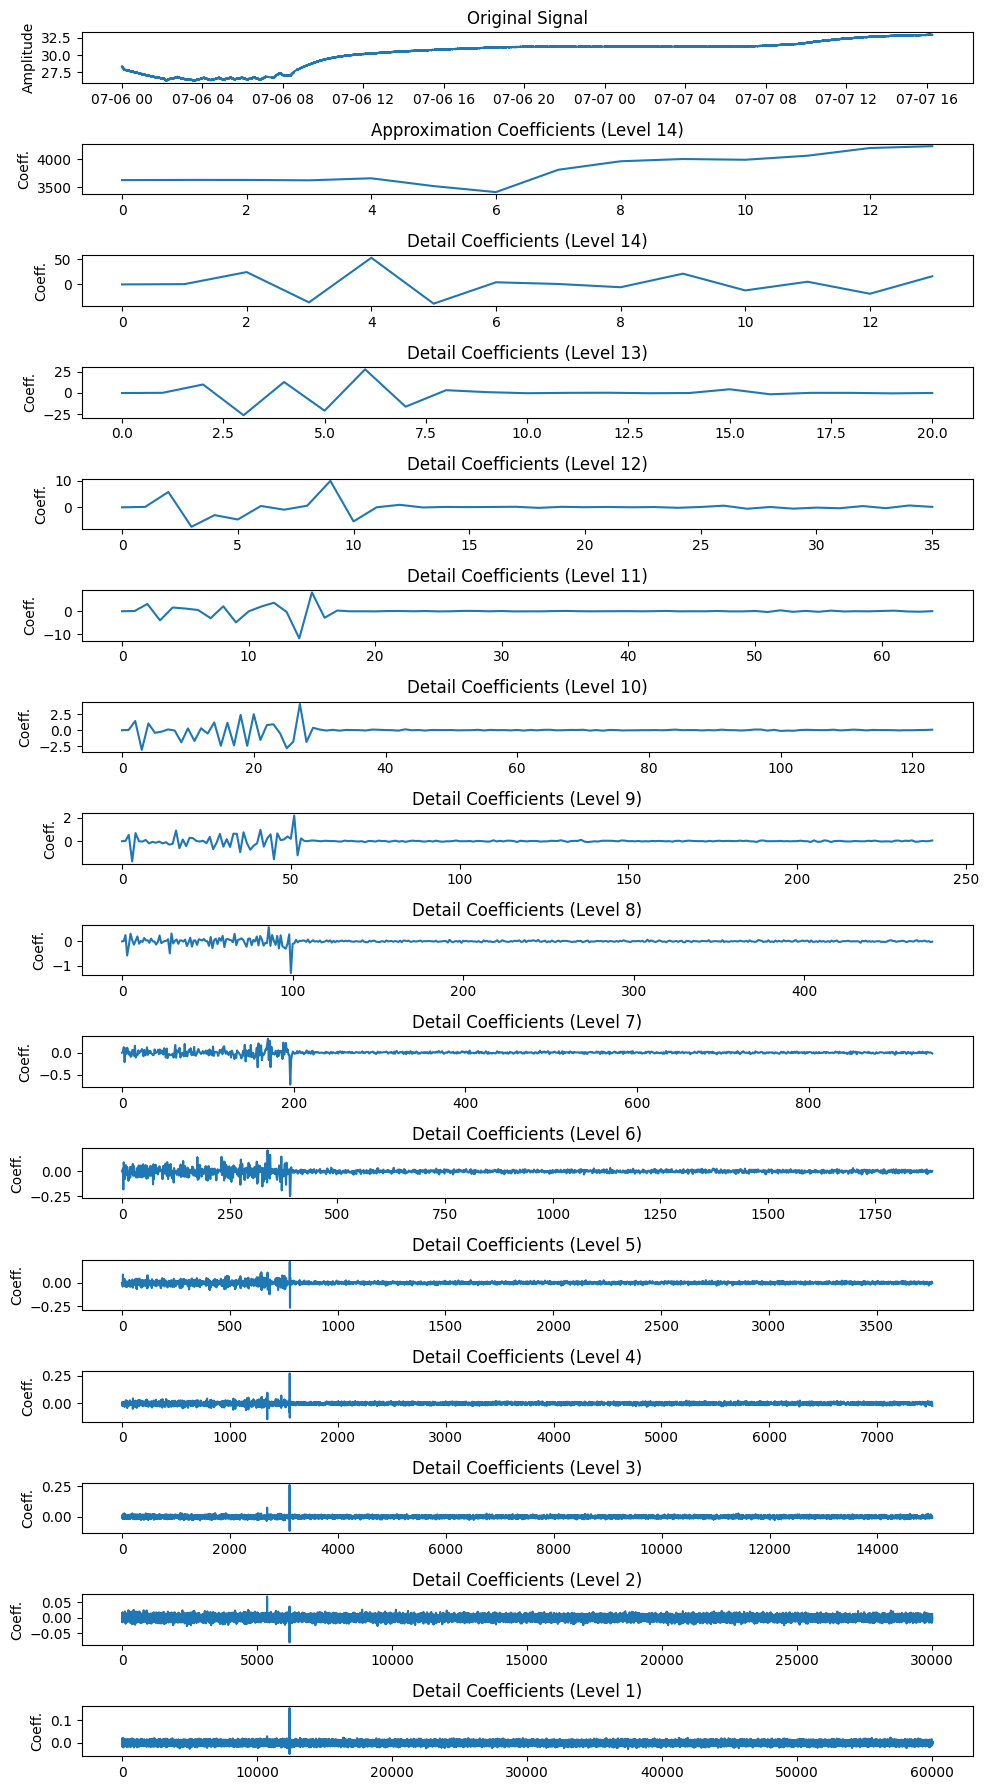

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

df_samp = df[df['sensor_id']=='PICO_W_01']
t = df_samp['obs_time']
signal = df_samp['temp']

# Choose a wavelet and decomposition level
wavelet = 'db4'
max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)

# Perform multi-level discrete wavelet decomposition
coeffs = pywt.wavedec(signal, wavelet, level=max_level)

# Plot original signal and wavelet coefficients
fig, axes = plt.subplots(len(coeffs) + 1, 1, figsize=(10, 18))
axes[0].plot(t, signal)
axes[0].set_title('Original Signal')
axes[0].set_ylabel('Amplitude')

for i, coeff in enumerate(coeffs):
    if i == 0:
        axes[i+1].plot(coeff)
        axes[i+1].set_title(f'Approximation Coefficients (Level {max_level})')
    else:
        axes[i+1].plot(coeff)
        axes[i+1].set_title(f'Detail Coefficients (Level {max_level - i + 1})')
    axes[i+1].set_ylabel('Coeff.')

plt.tight_layout()
plt.show()

In [ ]:
scales

array([1.0000e+00, 1.0540e+03, 2.1060e+03, 3.1590e+03, 4.2110e+03,
       5.2640e+03, 6.3160e+03, 7.3690e+03, 8.4220e+03, 9.4740e+03,
       1.0527e+04, 1.1579e+04, 1.2632e+04, 1.3685e+04, 1.4737e+04,
       1.5790e+04, 1.6842e+04, 1.7895e+04, 1.8947e+04, 2.0000e+04])

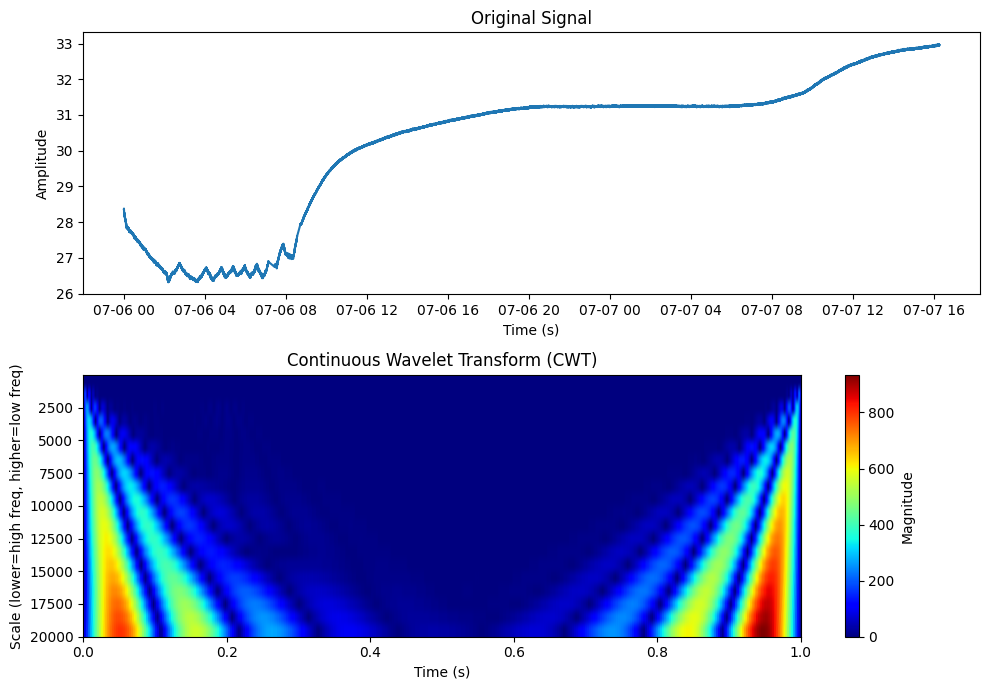

In [ ]:
# Define a fine-grained range of scales (for smooth steps)
scales = np.round(np.linspace(1, 20000, 20))  # 200 smoothly spaced scales from 1 to 50

# Perform Continuous Wavelet Transform using the Morlet wavelet
coefficients, frequencies = pywt.cwt(signal, scales, 'morl')

# Plot original signal
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot the CWT coefficients as a heatmap
plt.subplot(2, 1, 2)
plt.imshow(np.abs(coefficients), extent=[0, 1, scales[-1], scales[0]],
           cmap='jet', aspect='auto', vmax=np.abs(coefficients).max(), vmin=0)
plt.colorbar(label="Magnitude")
plt.title("Continuous Wavelet Transform (CWT)")
plt.xlabel("Time (s)")
plt.ylabel("Scale (lower=high freq, higher=low freq)")
plt.tight_layout()
plt.show()

In [ ]:
df_samp.shape

(120084, 12)

In [ ]:
for step in coeffs:
    print(len(step))

14
14
21
36
65
124
241
476
945
1883
3759
7511
15016
30026
60045


## Next Steps
- calculate exponentially smoothed averages